<a href="https://colab.research.google.com/github/jungbok/CNN_Image_Colorization/blob/master/lab6_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNNs for Image Colorization
JungBok Lee
6896785721


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
# import cv2
from matplotlib.colors import to_hex
from skimage.color import rgb2gray

a) Download the CIFAR-10 dataset

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
images before normalization: 


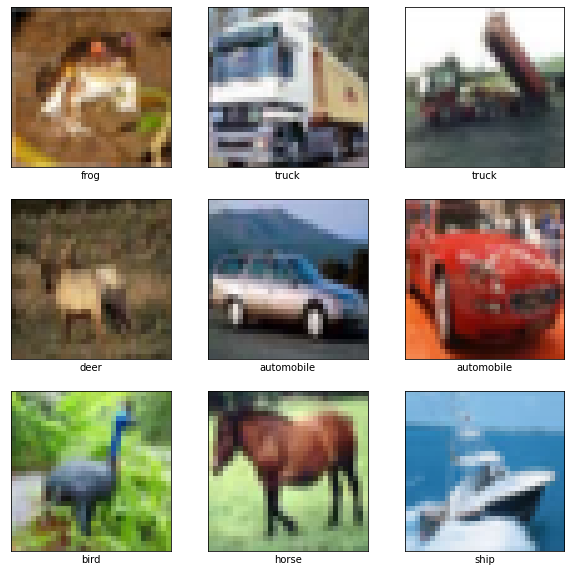

images after normalization: 


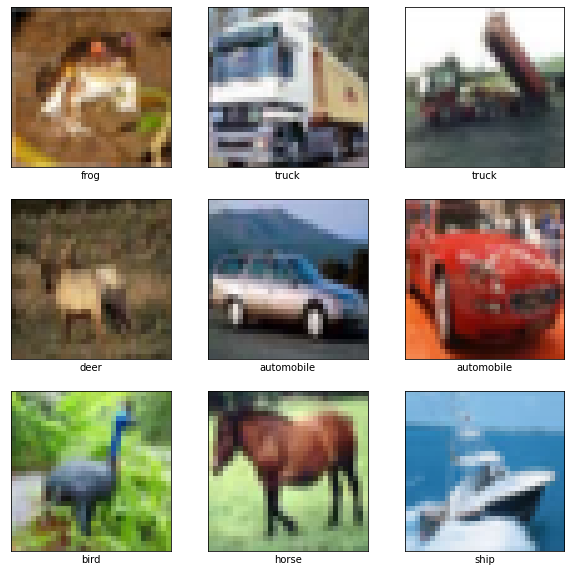

In [35]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1 - Necessary?
# train_images, test_images = train_images / 255.0, test_images / 255.0

# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

# Normalized images
nol_train_images, nol_test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# plot 9 images function
def plot9Images(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(9):
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(class_names[labels[i][0]])
  plt.show()

print("images before normalization: ")
plot9Images(train_images, train_labels)
print("images after normalization: ")
plot9Images(nol_train_images, train_labels)

b) From the train and test dataset, extract the class birds

Train Index Shape for the class Bird: (50000,)
Test Index Shape for the class Bird: (10000,)
Train dataset labelled as bird


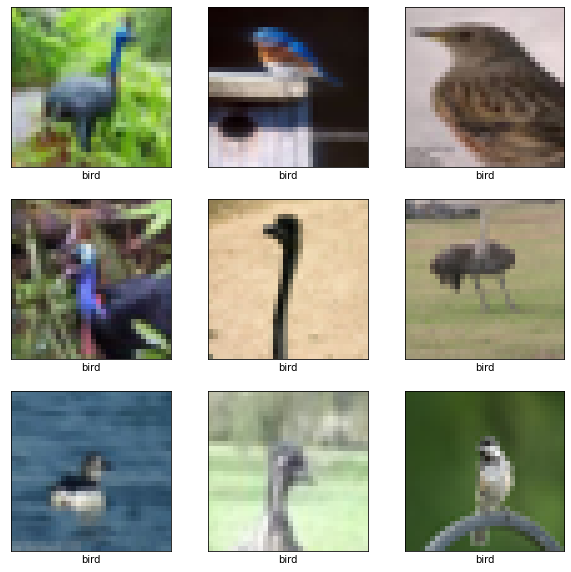

Test dataset labelled as bird


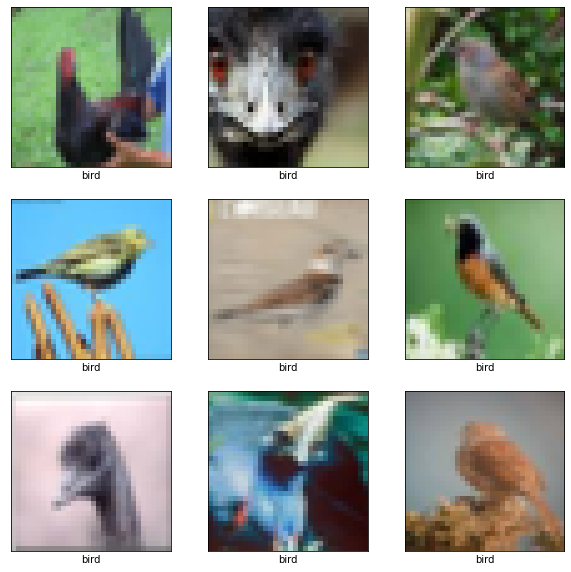

In [36]:
# currently using normalized data
idx = (train_labels == 2).reshape(train_images.shape[0])
print('Train Index Shape for the class Bird: {}'.format(idx.shape))
bird_train_images = nol_train_images[idx]
bird_train_labels = train_labels[idx]

t_idx = (test_labels == 2).reshape(test_images.shape[0])
print('Test Index Shape for the class Bird: {}'.format(t_idx.shape))
bird_test_images = nol_test_images[t_idx]
bird_test_labels = test_labels[t_idx]

print("Train dataset labelled as bird")
plot9Images(bird_train_images, bird_train_labels)
print("Test dataset labelled as bird")
plot9Images(bird_test_images, bird_test_labels)


# currently not using normalized data
#idxc = (train_labels == 3).reshape(train_images.shape[0])
#print('Train Index Shape for the class Bird: {}'.format(idxc.shape))
#cat_train_images = train_images[idxc]
#cat_train_labels = train_labels[idxc]
#plot9Images(cat_train_images, cat_train_labels)

c) Images have 6000 X 32 X 32 pixels: choose at least 10% of the pixels randomly. P = 614400 and P = 6144000 pixels

In [37]:
row = np.random.randint(32, size=None)
col = np.random.randint(32)
image = np.random.randint(6000)

# random 80% of the pixel -> 6144000 * 0.8 =. 4915200
randPix = np.random.randint([32, 32, 600], size=(6144000,1,3))
print(randPix.shape)
# print(randPix[:10, 0, 1])

bird_images = np.concatenate([bird_train_images, bird_test_images])
print("bird_images(train, test combined) shape: ", bird_images.shape)
rsbirds = bird_images[randPix[:,0,2], randPix[:,0,1], randPix[:,0,0], :]

print("RGB of pixel chosen")
print(rsbirds[:3])

(6144000, 1, 3)
bird_images(train, test combined) shape:  (6000, 32, 32, 3)
RGB of pixel chosen
[[0.84313725 0.74117647 0.63529412]
 [0.52156863 0.44705882 0.34509804]
 [0.37647059 0.54509804 0.76078431]]


d) Run k-means clustering on the P vectors using K = 4

In [38]:
rsbirdsAll = bird_images.reshape(6144000, 3)
print(rsbirdsAll[:3, :])
kmeans = KMeans(n_clusters=4, init='random', random_state=None).fit(rsbirdsAll)
# clusters = kmeans.fit_predict(rsbirds)
# print(clusters.shape)
print(kmeans.labels_)
# print(kmeans.shape)
palette = kmeans.cluster_centers_

[[0.64313725 0.80784314 0.32941176]
 [0.41176471 0.54901961 0.23921569]
 [0.4627451  0.58039216 0.39607843]]
[0 3 3 ... 0 0 0]


Palette RGB val:  [[0.61722087 0.61539321 0.54016189]
 [0.81510776 0.83559034 0.83440618]
 [0.19537268 0.19920284 0.1535353 ]
 [0.43293605 0.43118153 0.32857431]]
#9d9d8a


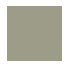

#d0d5d5


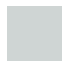

#323327


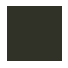

#6e6e54


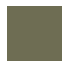

In [39]:
print("Palette RGB val: ", palette)
palette_list = list()
for color in palette:
    palette_list.append([[tuple(color)]])

# Show color palette
for color in palette_list:
    print(to_hex(color[0][0]))
    plt.figure(figsize=(1, 1))
    plt.axis('off')
    plt.imshow(color);
    plt.show();
#palette.reshape(())

e) Obtain Grayscale images from the origianl images

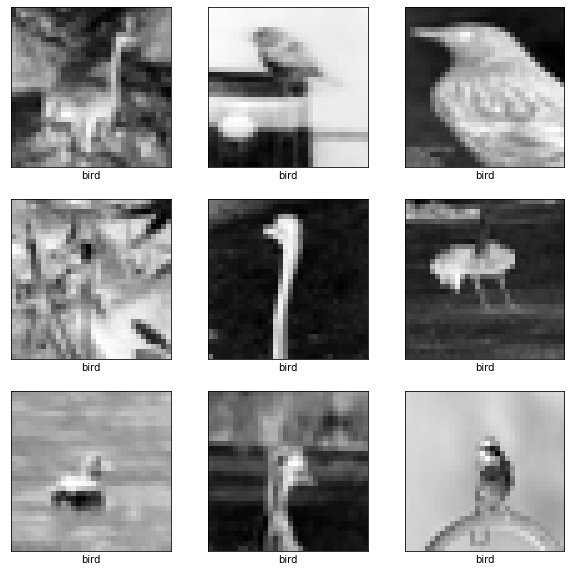

In [40]:
# using skimage
# RGB2GRAY
gray_bird_image = []

for i in range(bird_images.shape[0]):
    gray_bird_image.append(rgb2gray(bird_images[i]))
gray_bird_image = np.asarray(gray_bird_image)
plot9Images(gray_bird_image, bird_train_labels)

f) Deep Convolutional Neural Network with two convolutional layers and two MLP layers

In [41]:
# using 5*5 filters and a softmax output layer
gray_bird_image = gray_bird_image.reshape((6000, 32, 32, 1))
print(gray_bird_image.shape)
train_gray_bird = gray_bird_image[:5000]
test_gray_bird = gray_bird_image[5000:]

print(train_gray_bird[0, 0, 0])
print(test_gray_bird.shape[0])

def make_cnn_model(image_size, class_size = 4, extra_layer=0):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # Extra Layers

  # reshaping the output - 4 default class for k=4
  model.add(layers.Flatten())
  model.add(layers.Dense(8192, activation='relu'))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Reshape((32,32,4)))
  model.add(layers.Softmax())
  #model.add(layers.Dense(32, activation='relu'))
  
  #model.add(layers.Dense(class_size))

  model.summary()

  return model


(6000, 32, 32, 1)
[0.73834824]
1000


In [42]:
model = make_cnn_model(32, class_size=4)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              4202496   
_________________________________________________________________
dense_3 (Dense)              (None, 4096)             

In [43]:
k4_hot_encoding = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
# y_train = tf.constant(y_train, shape=[4, 4])
print(kmeans.labels_)
# print(kmeans.shape)
y_train = []
for i in range(len(kmeans.labels_)):
  if kmeans.labels_[i] == 0:
    y_train.append(k4_hot_encoding[0])
  elif kmeans.labels_[i] == 1:
      y_train.append(k4_hot_encoding[1])
  elif kmeans.labels_[i] == 2:
      y_train.append(k4_hot_encoding[2])
  else:
      y_train.append(k4_hot_encoding[3])


[0 3 3 ... 0 0 0]


In [44]:
#print(y_train.shape)
y_encoded = np.array(y_train)

y_encoded = y_encoded.reshape((-1,32, 32, 4))
y_encoded =np.array(y_encoded)
print(y_encoded.shape)
#print()

(6000, 32, 32, 4)


In [45]:
# compile and train
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gray_bird, y_encoded[:5000], epochs=30, 
                    validation_data=(test_gray_bird, y_encoded[5000:]))

Epoch 1/30
157/157 [==============================] - 69s 435ms/step - loss: 1.3586 - accuracy: 0.3255 - val_loss: 1.2255 - val_accuracy: 0.4158
Epoch 2/30
157/157 [==============================] - 67s 429ms/step - loss: 1.1762 - accuracy: 0.4575 - val_loss: 1.0970 - val_accuracy: 0.5034
Epoch 3/30
157/157 [==============================] - 68s 436ms/step - loss: 1.0858 - accuracy: 0.5084 - val_loss: 1.0635 - val_accuracy: 0.5198
Epoch 4/30
157/157 [==============================] - 69s 439ms/step - loss: 1.0385 - accuracy: 0.5344 - val_loss: 1.0419 - val_accuracy: 0.5291
Epoch 5/30
157/157 [==============================] - 69s 439ms/step - loss: 1.0099 - accuracy: 0.5480 - val_loss: 1.0214 - val_accuracy: 0.5438
Epoch 6/30
157/157 [==============================] - 69s 439ms/step - loss: 0.9815 - accuracy: 0.5615 - val_loss: 1.0049 - val_accuracy: 0.5490
Epoch 7/30
157/157 [==============================] - 69s 439ms/step - loss: 0.9478 - accuracy: 0.5778 - val_loss: 1.0434 - val_ac

In [46]:
# one-hot encoding to k cluster pixel val
# [0 0 1 0] -> [0.234 0.334 0.435]

# train_loss, train_acc = model.evaluate(train_gray_bird, y_encoded[:5000], verbose=1)
# predict
# train_pred
# train_pred = model.predict(train_gray_bird)
'''
# train prediction
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend(loc='lower right')
plt.show()
'''
# print(history.history)
# change y_encoded to actual/original image? 

"\n# train prediction\nplt.plot(history.history['accuracy'], label='accuracy')\nplt.plot(history.history['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Train Accuracy')\nplt.ylim([0.0, 1])\nplt.legend(loc='lower right')\nplt.show()\n\nplt.plot(history.history['loss'], label='loss')\nplt.plot(history.history['val_loss'], label='val_loss')\nplt.xlabel('Epoch')\nplt.ylabel('Train Loss')\nplt.legend(loc='lower right')\nplt.show()\n"

In [ ]:
# print(history.history)
# change y_encoded to actual/original image? 
test_loss, test_acc = model.evaluate(test_gray_bird, y_encoded[5000:], verbose=1)
# predict
pred_test = model.predict(test_gray_bird)
print(pred_test.shape)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# prediction[i] = clusters_center_[prediction[i]]
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

p_t_shape:  (1000, 1024, 4)
K_color_pixels (1000, 32, 32, 3)


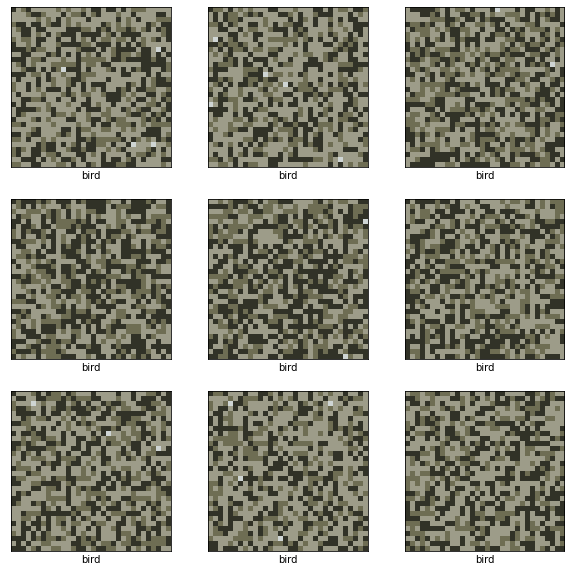

In [47]:
pred_test = pred_test.reshape((-1, 1024, 4))
print("p_t_shape: ", pred_test.shape)
# argmax returns the indices of the maximum value along an axis
pred_labels = np.argmax(pred_test, axis=2)
# print("pred_labels: ", pred_labels[:10])
k_color_pixels = []
for x in pred_labels:
  k_color_pixels.append(kmeans.cluster_centers_[x])
k_color_pixels = np.array(k_color_pixels)
k_color_pixels = k_color_pixels.reshape((1000, 32, 32,3))
print("K_color_pixels", k_color_pixels.shape)
# print(k_color_pixels[:3])
plot9Images(k_color_pixels, bird_test_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


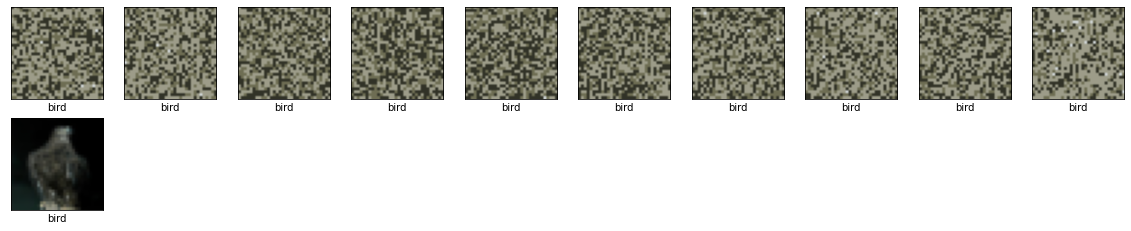

In [72]:
def plot10Images(images, labels, og_images, og_labels):
  plt.figure(figsize=(20,20))
  for i in range(10):
      plt.subplot(10, 10, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(class_names[labels[i][0]])

      plt.subplot(10, 10 , i+2)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(og_images[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[og_labels[i][0]])
  plt.show()

plot10Images(k_color_pixels, bird_test_labels, bird_test_images, bird_test_labels)